# Self-Organized Criticality: Sandpile
This is our week 7 examples notebook and will be available on Github from the powderflask/cap-comp215 repository.

Many complex systems "self-organize" to produce emergent behaviours that are nearly impossible to predict.
A simple system that illustrates this property is called "Sandpile" (though it is not a good model of a physical sandpile!)

Credits:
    Original code examples from Think Complexity, 2nd edition.
    Copyright 2016 Allen Downey, MIT License

As usual, the first code block just imports the modules we will use.

In [1]:
%matplotlib inline

import math
import time
from dataclasses import dataclass

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Helpers
We're starting to collect some useful re-usable bits of code - we should consider putting these in an importable module...

In [2]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = 'Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [3]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step*self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [4]:
class FrequencyDist:
    """ Represents the Frequency Distribution for a set of observations on a discrete random variable """
    def __init__(self, observations, labels: dict=None, title='Trials'):
        """ observations is a 1D sequence of empirical data, labels optionally relabel observation values """
        self.n_obs = len(observations)
        self.title = title

        # frequency for each unique category
        self.categories, self.counts = np.unique(observations, return_counts=True)
        self.n_cat = len(self.categories)
        self.proportions = self.counts/self.n_obs
        # matching category labels, if supplied
        self.category_labels = tuple(labels[c] for c in self.categories) if labels else self.categories

    def get_frequencies(self):
        """ Return the frequency count of each category as a dict """
        return {
            cat: freq for cat, freq in zip(self.category_labels, self.counts)
        }

    def print_frequencies(self):
        """ Print the frequency of each category as a fraction of observations """
        print(f'{self.title}:', [f'p({o})=", {n}/{self.n_obs}' for o, n in self.get_frequencies().items()] )

    def bar(self, axes=None, **options):
        """ Plot distribution as a bar chart. """
        axes = axes or plt.gca()  # If no axes are provided, draw on current axes
        axes.set(**options)
        axes.set_title(f'Frequency distribution for {self.n_obs} {self.title}')
        axes.bar(self.category_labels, self.proportions)

    def plot(self, axes=None, **options):
        """ Plot distribution as a line graph. """
        axes = axes or plt.gca()  # If no axes are provided, draw on current axes
        axes.set(**options)
        axes.set_title(f'Frequency distribution for {self.n_obs} {self.title}')
        axes.plot(self.categories, self.proportions)

## Simple Sandpile Model
The Abelian sandpile model (ASM) was the first discovered example of a dynamical system displaying self-organized criticality. It was introduced by Per Bak, Chao Tang and Kurt Wiesenfeld in a 1987 paper.

The model is a cellular automaton: each site on a finite grid has an associated value that corresponds to the height of the pile. This height builds up as "grains of sand" (or "rice") are randomly placed onto the pile, until the height exceeds a specific threshold value at which time that site collapses transferring sand into the adjacent sites, increasing their height. Bak, Tang, and Wiesenfeld considered process of successive random placement of sand grains on the grid; each such placement of sand at a particular site may have no effect, or it may cause a cascading reaction that will affect many sites.  [wikipedia](https://en.wikipedia.org/wiki/Abelian_sandpile_model)

Here's a small example starting with two cells set to topple...

In [5]:
n = 5
pile = np.zeros((n, n), dtype=np.int32)
pile[2, 1] = 4
pile[2, 3] = 4
print(pile)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 4 0 4 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


Identify all the cells that are about to "topple", or slide into their neighbours...

In [6]:
critical_slope = 3
toppling = pile > critical_slope
print(toppling.astype(int))

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


Use a simple diffusion kernel to move sand out of the toppled cells an into the neighbours...

In [7]:
kernel = np.array([[0,  1, 0],
                   [1, -4, 1 ],
                   [0,  1, 0]])

c = correlate2d(toppling, kernel, mode='same', boundary='fill', fillvalue=0)
print(c)

[[ 0  0  0  0  0]
 [ 0  1  0  1  0]
 [ 1 -4  2 -4  1]
 [ 0  1  0  1  0]
 [ 0  0  0  0  0]]


and finally add the toppled sand back into the pile.  Grains that topple off the edge just disappear.

In [8]:
pile += c
print(pile)

[[0 0 0 0 0]
 [0 1 0 1 0]
 [1 0 2 0 1]
 [0 1 0 1 0]
 [0 0 0 0 0]]


## SandPile CA class
As usual, let's package that behaviour into a reusable class

Start with sand uniformly spread on the grid.

In [9]:
class SandPile:
    """ Diffusion CA with a single grids, representing the slope or height of a pile of "sand" (or rice or chips). """

    # Critical "slope" beyond which sand topples / slides
    critical = 3
    # Slide to cardinal neighbours
    kernel = np.array([[0,  1, 0],
                       [1, -4, 1 ],
                       [0,  1, 0]])

    def __init__(self, n, initial_level=3):
        """ Initializes nxn model with sand spread evenly at given initial_level """
        self.state = np.ones((n, n), dtype=np.int32) * initial_level
        self.centre = (n//2, n//2)
        self.toppled_seq = []

    def topple(self):
        """ Simulate one time step and return the number of cells that toppled """
        toppling = self.state > self.critical
        num_toppled = np.sum(toppling)
        self.toppled_seq.append(num_toppled)

        c = correlate2d(toppling, self.kernel, mode='same')
        self.state += c
        return num_toppled

    def drop(self):
        """ Drop "sand" on the centre cell."""
        self.state[self.centre] += 1

    def run(self):
        """ Run the sandpile forward until it reaches equilibrium.

        returns: avalanche duration, avalanche size (total number of topplings)
        """
        size = 0
        duration = 0
        while (num_toppled := self.topple()) > 0:
            size += num_toppled
            duration +=1

        return duration, size

    def drop_and_run(self):
        """ Drop a grain of sand and run model to equilibrium. """
        self.drop()
        return self.run()

    # alias for drop_and_run used by animation
    step = drop_and_run

    def plot_toppling_history(self, axes=None, title='SandPile: Toppled Cell History'):
        """ Plot the history of number of cells toppled in this model """
        axes = axes or plt.gca()
        axes.set_title(title)
        axes.set_xlabel("Time Steps")
        axes.set_ylabel("Number of toppled cells")
        axes.plot(self.toppled_seq)

    def draw(self, axes=None, step=''):
        """Draws the cells on given axes."""
        axes = axes or plt.gca()  # use current axes if none are provided.
        plot_2D_array(self.state, axes, cmap='YlOrRd', vmax=5,  title=f'Sandpile {step}')

In [19]:
sandpile = SandPile(n=20)
anim = Animation2D(sandpile, frames=100)
anim.show()

After a while, the pile looks pretty random.

Here's a plot of the number of cells toppled after each `step`.

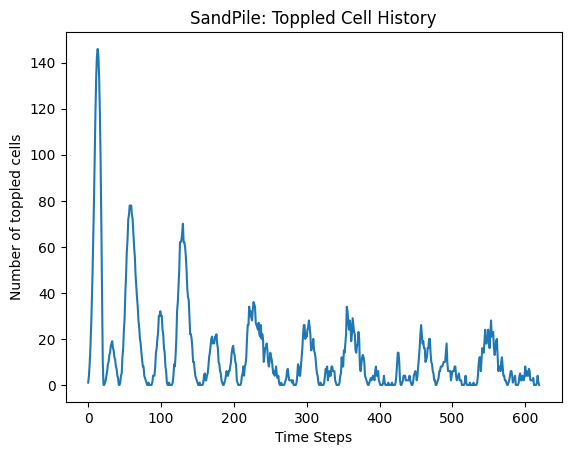

In [20]:
sandpile.plot_toppling_history()

The following figure shows the progression of the pile from ordered to apparently random.

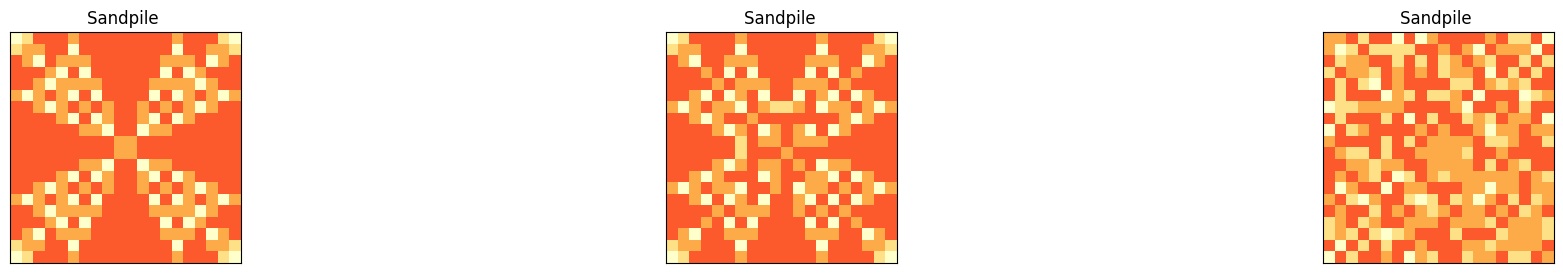

In [21]:
sandpile = SandPile(n=20, initial_level=4)
_, ax = plt.subplots(1, 3, figsize=(24, 3))

sandpile.run()
sandpile.draw(ax[0])

for step in range(20):
    sandpile.step()
sandpile.draw(ax[1])

for step in range(2000):
    sandpile.step()
sandpile.draw(ax[2])

## Heavy-tailed distributions

If the sand pile is in a critical state, we expect quantities like the duration of an avalanche, `T`, and the number of cells affected, `S`, to have heavy-tailed distributions.

Following Bak, Tang, and Wiesenseld, we start with a 50x50 array and plot the Frequency Distribution of `S` and `T` on a log-log scale.

In [22]:
sandpile2 = SandPile(n=50, initial_level=4)
sandpile2.run()

(678, 398660)

Now we run the pile for many time steps and keep track of the durations and number of cells affected.

In [23]:
steps = 5000
%time results = [sandpile2.drop_and_run() for _ in range(steps)]

CPU times: user 2.8 s, sys: 75.7 ms, total: 2.88 s
Wall time: 2.88 s


We can use `np.transpose` to extract the results as two NumPy arrays.

A large majority of drops have duration 1 and no toppled cells.  We filter them out to get a clearer picture of the rest of the distribution.

In [24]:
T, S = np.transpose(results)
T = T[T>1]
S = S[S>1]

Plot the frequency distribution of `T` and `S`.

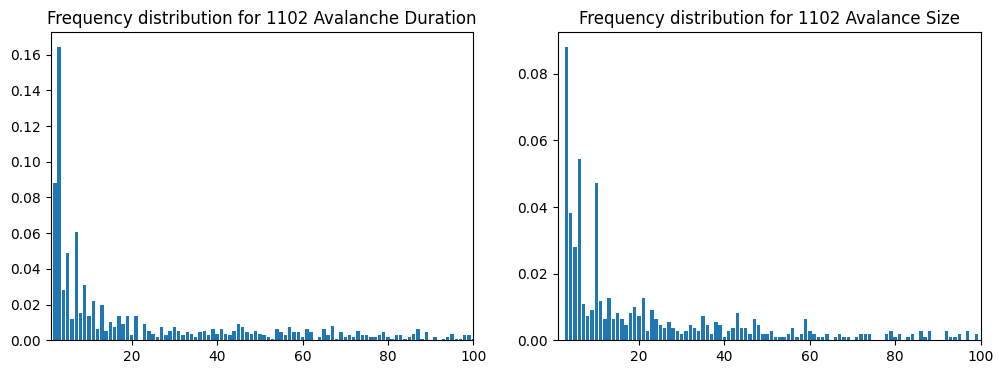

In [25]:
T_dist = FrequencyDist(T, title='Avalanche Duration')
S_dist = FrequencyDist(S, title='Avalance Size')

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

T_dist.bar(ax1, xlim=(1,100))
S_dist.bar(ax2, xlim=(1,100))

Plot on log-log scale against a line with slope -1 to look for evidence of a "heavy-tail"...

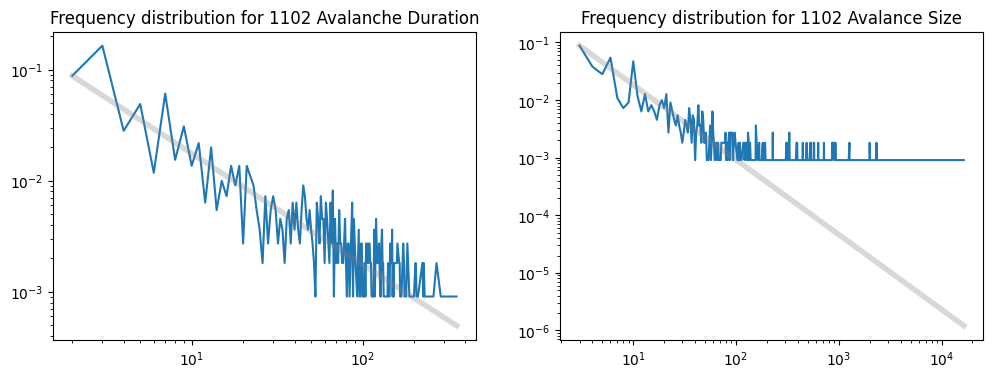

In [26]:
EPSILON = 0.00001  # min. anticipated accuracy for slope calculation

def log_slope(xs, ys):
    """ Return slope in log-space """
    return np.diff(np.log(ys)) / np.diff(np.log(xs))

def plot_sloped_line(dist, slope=-1, axes=None):
    """ Plot a line with log-log slope from the first point in the dist """
    axes = axes or plt.gca()
    xs = [dist.categories[0], dist.categories[-1]]
    ys = [dist.proportions[0], None]
    ys[1] = ys[0] * np.exp(slope*np.log(xs[1]/xs[0]))  # compute y1 so line has a slope exactly -1
    assert log_slope(xs, ys) - slope < EPSILON
    axes.plot(xs, ys, color='gray', alpha=0.3, linewidth=4)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
T_dist.plot(ax1, xscale='log', yscale='log')
plot_sloped_line(T_dist, slope=-1, axes=ax1)
S_dist.plot(ax2, xscale='log', yscale='log')
plot_sloped_line(S_dist, slope=-1.3, axes=ax2)